# 03_model_development.ipynb

In [1]:
# Model Development Libraries 
import os
import json
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Paths
DATASET_DIR = "../data/raw/EuroSAT_RGB"
OUTPUT_DIR = "../data/processed"
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
# Load class mappings
with open(os.path.join(OUTPUT_DIR, "class_mappings.json"), "r") as f:
    mappings = json.load(f)
    class_to_idx = mappings["class_to_idx"]
    idx_to_class = {int(k): v for k, v in mappings["idx_to_class"].items()}  # Convert keys back to integers

num_classes = len(class_to_idx)
print(f"Num classes: {num_classes}")

Num classes: 10


In [4]:
# Load data splits
splits = torch.load(os.path.join(OUTPUT_DIR, 'dataset_splits.pt'))
train_indices = splits['train_indices']
val_indices = splits['val_indices'] 
test_indices = splits['test_indices']

In [5]:
# Create dataset and dataloaders using the same code from previous notebook
class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.jpg'):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
])

In [7]:
# Create datasets
full_dataset = EuroSATDataset(DATASET_DIR, transform=None)

# Create subsets using the saved indices
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

In [8]:
# Apply transformations
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.subset)

train_dataset = TransformedSubset(train_dataset, train_transform)
val_dataset = TransformedSubset(val_dataset, val_transform)
test_dataset = TransformedSubset(test_dataset, val_transform)

In [9]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) # Set > 0 for parallel data loading
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [10]:
# Define function to create and train a model
def create_model(model_name='resnet18', freeze_backbone=True):
    """
    Creates and configures a CNN model for image classification tasks.

    Args:
        model_name (str, optional): The name of the model architecture to use. Supported models are 'resnet18', 'resnet50', 'efficientnet_b0', and 'efficientnet_b4.
        freeze_backbone (bool, optional): Whether to freeze the weights of the model's backbone. Defaults to True.

    Returns:
        torch.nn.Module: The configured model.

    Raises:
        ValueError: If the specified model_name is not supported.
    """
    # Load pretrained model
    if model_name == 'resnet18':
        model = models.resnet18(weights='IMAGENET1K_V1')
    elif model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V1')
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    elif model_name == 'efficientnet_b4':
        model = models.efficientnet_b4(weights='IMAGENET1K_V1')
    else:
        raise ValueError(f"Model {model_name} not supported")
    
    # Freeze backbone if specified
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the last fully connected layer
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name.startswith('efficientnet'):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    return model

In [11]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    # For tracking metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                if scheduler:
                    scheduler.step()
            else:  # val
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model if best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [12]:
# Create and train the model
model_name = 'resnet18'  # Choose from: 'resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b4'
freeze_backbone = True   # Whether to freeze the pretrained layers (only weights in classifier head are updated during training)
model = create_model(model_name, freeze_backbone)

In [13]:
# Define loss function, optimizer, scheduler, num_epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 10

In [14]:
# Train the model
print(f"Training {model_name} with {'frozen' if freeze_backbone else 'unfrozen'} backbone:")
start_time = time.time()
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs)
time_elapsed = time.time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Training resnet18 with frozen backbone:
Epoch 1/10
----------
train Loss: 0.9775 Acc: 0.6834
val Loss: 0.6929 Acc: 0.7901

Epoch 2/10
----------
train Loss: 0.7262 Acc: 0.7609
val Loss: 0.6297 Acc: 0.8035

Epoch 3/10
----------
train Loss: 0.7158 Acc: 0.7617
val Loss: 0.6308 Acc: 0.8000

Epoch 4/10
----------
train Loss: 0.7050 Acc: 0.7657
val Loss: 0.6018 Acc: 0.8153

Epoch 5/10
----------
train Loss: 0.6911 Acc: 0.7692
val Loss: 0.6078 Acc: 0.8081

Epoch 6/10
----------
train Loss: 0.6757 Acc: 0.7763
val Loss: 0.5772 Acc: 0.8180

Epoch 7/10
----------
train Loss: 0.6969 Acc: 0.7720
val Loss: 0.5930 Acc: 0.8126

Epoch 8/10
----------
train Loss: 0.6526 Acc: 0.7839
val Loss: 0.5826 Acc: 0.8126

Epoch 9/10
----------
train Loss: 0.6412 Acc: 0.7872
val Loss: 0.6019 Acc: 0.8084

Epoch 10/10
----------
train Loss: 0.6296 Acc: 0.7902
val Loss: 0.5554 Acc: 0.8217

Training complete in 12m 30s


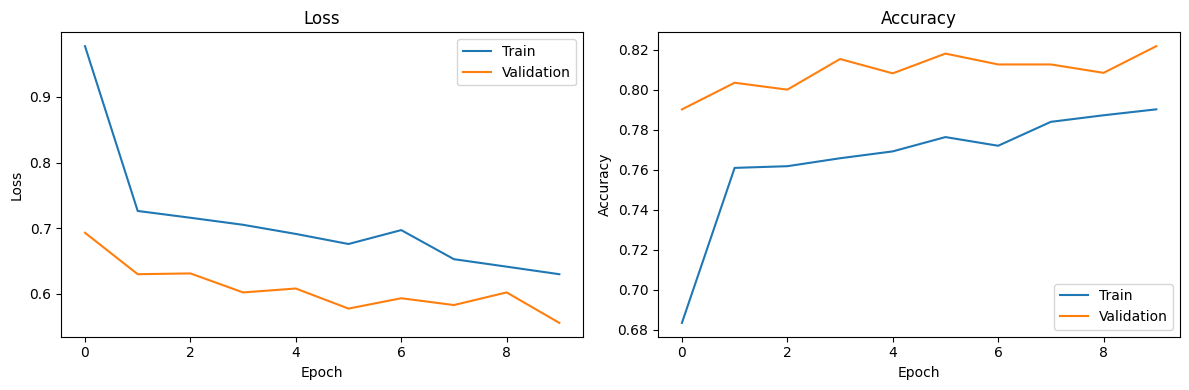

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title(f'{model_name} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title(f'{model_name} - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Save the model
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
model_save_path = os.path.join(MODEL_DIR, f"{model_name}_{'frozen' if freeze_backbone else 'unfrozen'}_{timestamp}.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'model_name': model_name,
    'freeze_backbone': freeze_backbone,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'model_name': model_name,
    'freeze_backbone': freeze_backbone,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': optimizer.param_groups[0]['lr'],
    'history': history
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ../models\resnet18_frozen_20250406_1324.pth


In [17]:
# Evaluate on test set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

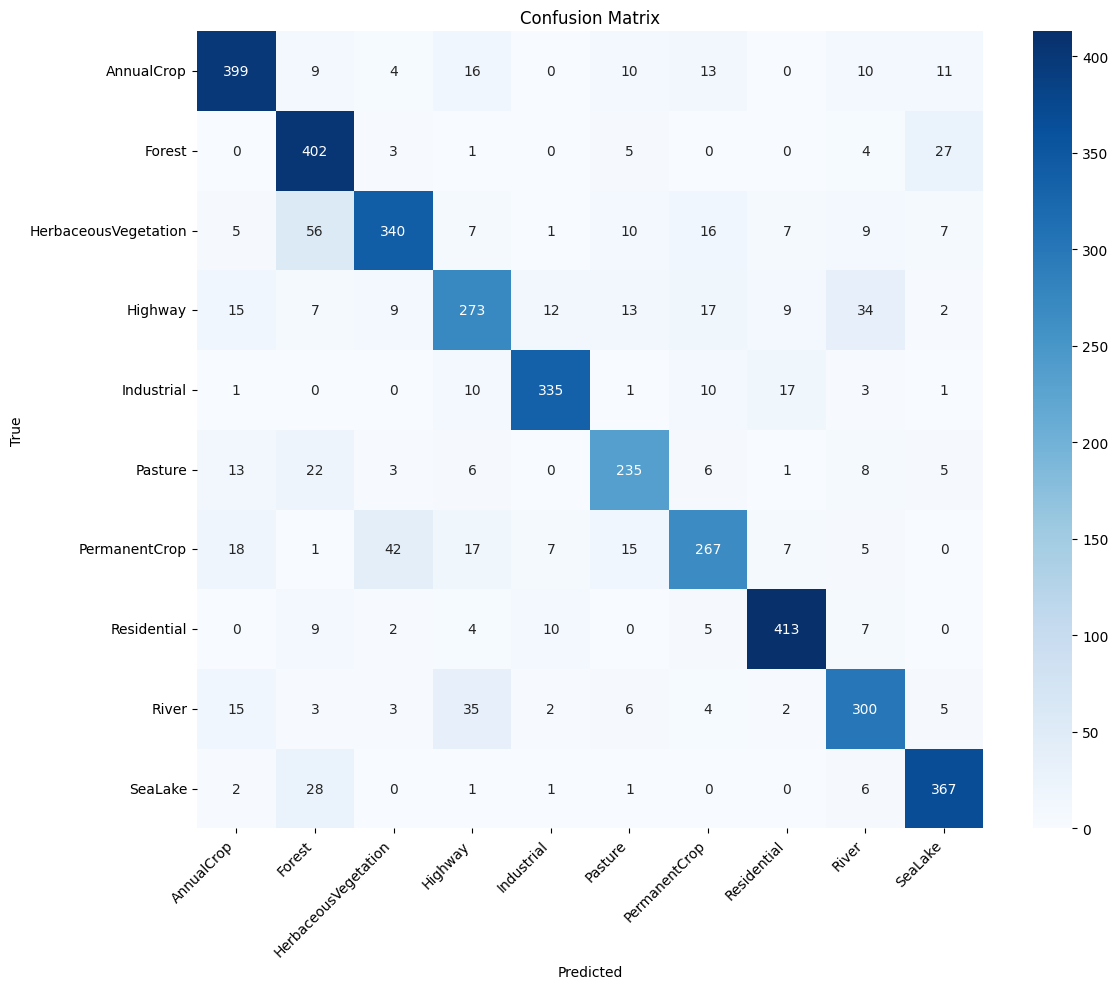

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = [idx_to_class[i] for i in range(num_classes)]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'{model_name} - Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Print classification report
print(f"Classification Report: {model_name}")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.85      0.85      0.85       472
              Forest       0.75      0.91      0.82       442
HerbaceousVegetation       0.84      0.74      0.79       458
             Highway       0.74      0.70      0.72       391
          Industrial       0.91      0.89      0.90       378
             Pasture       0.79      0.79      0.79       299
       PermanentCrop       0.79      0.70      0.74       379
         Residential       0.91      0.92      0.91       450
               River       0.78      0.80      0.79       375
             SeaLake       0.86      0.90      0.88       406

            accuracy                           0.82      4050
           macro avg       0.82      0.82      0.82      4050
        weighted avg       0.82      0.82      0.82      4050



In [20]:
# Test accuracy
test_acc = (np.array(y_true) == np.array(y_pred)).mean()
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.8225
